## View in Colab for latest version:

<a href="https://colab.research.google.com/drive/1h6iAM_rcj16Br2HX13rpRf6vkRPoUgid?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Read in Data

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from numpy import loadtxt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
import re
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWjPYa1YxrR9e1q653lPv5w7FbkwdvvX_tP2d-0Oa5UJZRT7hL0sezM


In [ ]:
# Upload from local machine
train = pd.read_csv('/content/drive/MyDrive/MIDS/capstone/data/processed/non_ca.csv')
predict = pd.read_csv('/content/drive/MyDrive/MIDS/capstone/data/processed/ca.csv')

train = train.iloc[: , 1:].dropna()
predict = predict.iloc[: , 1:].dropna()

In [ ]:
train.

# Set up Features

In [ ]:
#let's find the top 100 most correlated features

x = train.corr().tail(1)
top_100 = x.apply(pd.Series.nlargest, axis=1, n=100).columns


In [ ]:
full_features = [col for col in top_100.to_list() if col not in ['ev_label', 'ev_rate']]

In [ ]:
# Shuffle data into training and testing
np.random.seed(1440)
X=train[full_features]
y=train['ev_label']
X_train, X_dev, y_train, y_dev = train_test_split(X,y, train_size=.80, stratify = y)

In [ ]:
# Check out shapes
print('train features shape: ', X_train.shape)
print('dev features shape: ', X_dev.shape)
print('train label shape:', y_train.shape)
print('dev label shape:', y_dev.shape)

train features shape:  (6630, 98)
dev features shape:  (1658, 98)
train label shape: (6630,)
dev label shape: (1658,)


# Initial Modeling

## Logistic Regression

In [ ]:
lr = LogisticRegression(C= 1 , solver="lbfgs", multi_class="auto", class_weight='balanced').fit(X_train, y_train)
lr_predict = lr.predict(X_dev)
lr_score =  metrics.f1_score(lr_predict,y_dev,average="weighted")

In [ ]:
lr_score

0.27021387584767864

In [ ]:
print(confusion_matrix(y_dev, lr_predict))


[[  0   0   0 510]
 [  0   0   0 621]
 [  0   0   0 268]
 [  0   0   0 259]]


In [ ]:
train.ev_label.value_counts(normalize = True)

2.0    0.374397
1.0    0.307674
3.0    0.161680
4.0    0.156250
Name: ev_label, dtype: float64

In [ ]:
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{1:x, 2:1.0-x, 3:, 4: } for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1_macro', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.3s finished


ValueError: ignored

## Extreme Gradient Boost XGB

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_features, train_labels)
xgb_predict = xgb_model.predict(dev_features)
xgb_score =  metrics.f1_score(xgb_predict,dev_labels,average="weighted")

In [ ]:
xgb_score

0.6035562934277823

## K Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
best_score = []
all_k = []

for k in list(range(1,41)):
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(train_features, train_labels)
  prediction = knn_model.predict(dev_features)
  score =  metrics.f1_score(dev_labels, prediction, average="weighted")
  best_score.append(score)
  all_k.append(k)
     
#find max accuracy
knn_score = max(best_score)
#find index of max accuracy
index = best_score.index(max_score)
#find index for other values
best_k =all_k[index]

print("SCORE: ", knn_score, "MODEL: KNN","BEST K-Size:", best_k)

SCORE:  0.54506103553192 MODEL: KNN BEST K-Size: 22


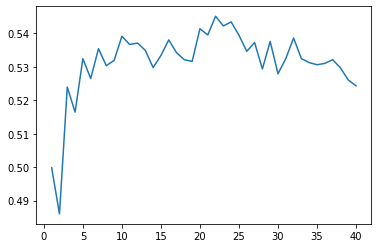

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(all_k, best_score)

## Naive Bayes

In [ ]:
# Multinomial Naive Bayes
alpha_vals = [ele/10 for ele in list(range(1,10))]
alpha_vals.insert(0, .01)
alpha_vals.insert(0, .001)
alpha_vals.insert(0, .0001)

best_score = []
all_alpha = []

for a in alpha_vals:
  nb_model = MultinomialNB(alpha = a)
  nb_model.fit(train_features, train_labels)
  prediction =nb_model.predict(dev_features)
  score =  metrics.f1_score(dev_labels, prediction, average="weighted")
  best_score.append(score)
  all_alpha.append(a)



# find max accuracy
mnb_score = max(best_score)
# find index of max accuracy
index = best_score.index(mnb_score)
# find index for other values
best_alpha =all_alpha[index]

print("SCORE: ", mnb_score, "MODEL: Multinomial Naive Bayes","BEST Alpha:", best_alpha)


SCORE:  0.3761345474318793 MODEL: Multinomial Naive Bayes BEST Alpha: 0.0001


## SVM

In [ ]:
from sklearn import svm


In [ ]:
# best_score = []
# best_C = []
# C =  [.01,.1,.5,.75,1,2,5] # SVM regularization parameter

# for i in C:
#   svc = svm.SVC(kernel='linear', C=i).fit(train_features, train_labels)
#   rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=i).fit(train_features, train_labels)
#   poly_svc = svm.SVC(kernel='poly', degree=3, C=i, gamma='auto').fit(train_features, train_labels)
#   predict_svc = svc.predict(dev_features)
#   predict_rbf_svc = rbf_svc.predict(dev_features)
#   predict_poly_svc  = poly_svc.predict(dev_features)
        
#   svc_score =  metrics.f1_score(dev_labels, predict_svc, average="weighted")
#   rbf_svc_score =  metrics.f1_score(dev_labels, predict_rbf_svc, average="weighted")
#   poly_svc_score =  metrics.f1_score(dev_labels, predict_poly_svc, average="weighted")

#   best_score.append(svc_score)
#   svc_accuracies.append(svc_score)
#   best_model.append('SVC')
#   best_c.append(i)
#   best_score.append(rbf_svc_score)
#   best_model.append('RBF SVC')
#   best_c.append(i)
#   best_score.append(poly_svc_score)
#   best_model.append('POLY SVC')
#   best_c.append(i)
 

# #find max accuracy
# max_score = max(best_score)
# index = best_score.index(max_score)
# best_model = best_model[index]
# best_c = best_c[index]
# print("Max Score: ",max_score,"Best Model: ",best_model,"Best C Value: ",best_c)

# plt.plot(C,svc_accuracies)
# plt.xlabel('C Regularization')
# plt.ylabel('Accuracy')
# plt.title('SVC Accuracies vs Regularization Parameter')

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
accuracy = []
depths = np.arange(1, 10, 1)
for i in depths:
  dtc_model = DecisionTreeClassifier(max_depth = i)
  dtc_model.fit(train_features, train_labels)
  score = dtc_model.score(dev_features, dev_labels)
  print("Accuracy on Dev Data: ", score)
  accuracy.append(score)


Accuracy on Dev Data:  0.37997587454764775
Accuracy on Dev Data:  0.4867310012062726
Accuracy on Dev Data:  0.5120627261761158
Accuracy on Dev Data:  0.5193003618817853
Accuracy on Dev Data:  0.525934861278649
Accuracy on Dev Data:  0.5217129071170085
Accuracy on Dev Data:  0.508443908323281
Accuracy on Dev Data:  0.508443908323281
Accuracy on Dev Data:  0.5060313630880579


In [ ]:
labeled_data.Year.value_counts(sort=False)

2016    10099
2017      752
Name: Year, dtype: int64

## Keras Neural Net

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
train_features.shape

(6630, 267)

### With continuous outcome

In [ ]:
train_num

6329    0.012048
1370    0.056180
8350    0.048843
7664    0.001563
7200    0.005128
          ...   
2119    0.029070
585     0.044922
7096    0.018500
4664    0.006426
5351    0.012891
Name: ev_rate, Length: 6630, dtype: float64

In [ ]:
dev_num

4406    0.036145
855     0.020951
1522    0.052155
7027    0.011305
263     0.020139
          ...   
6690    0.074935
3257    0.037500
233     0.027964
3455    0.018377
5472    0.033426
Name: ev_rate, Length: 1658, dtype: float64

In [ ]:
keras_model = Sequential()

keras_model.add(Dense(8, activation='relu', input_shape=(267,)))

keras_model.add(Dense(8, activation='relu'))

keras_model.add(Dense(1, activation='sigmoid'))


keras_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                   
keras_model.fit(train_features, train_num,epochs=8, batch_size=1, verbose=1)

Epoch 1/8
6630/6630 [==============================] - 8s 1ms/step - loss: 5324030369368367410708480.0000 - accuracy: 0.0504
Epoch 2/8
6630/6630 [==============================] - 7s 1ms/step - loss: 0.1231 - accuracy: 0.0495
Epoch 3/8
6630/6630 [==============================] - 7s 1ms/step - loss: 0.1220 - accuracy: 0.0460
Epoch 4/8
6630/6630 [==============================] - 8s 1ms/step - loss: 0.1227 - accuracy: 0.0477
Epoch 5/8
6630/6630 [==============================] - 11s 2ms/step - loss: 0.1221 - accuracy: 0.0508
Epoch 6/8
6630/6630 [==============================] - 12s 2ms/step - loss: 0.1230 - accuracy: 0.0498
Epoch 7/8
6630/6630 [==============================] - 8s 1ms/step - loss: 0.1237 - accuracy: 0.0510
Epoch 8/8
6630/6630 [==============================] - 7s 1ms/step - loss: 0.1237 - accuracy: 0.0480


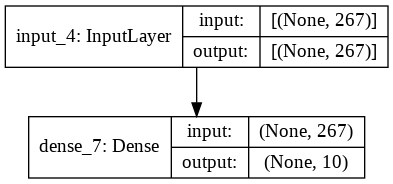

In [ ]:
keras.utils.plot_model(keras_model, "keras_model.png", show_shapes=True)


In [ ]:
keras_pred = keras_model.predict(dev_features)

score = keras_model.evaluate(dev_features, dev_num,verbose=1)

print(score)

52/52 [==============================] - 1s 1ms/step - loss: 0.1200 - accuracy: 0.0555
[0.1199917122721672, 0.05548854172229767]


### With binned outcome

In [ ]:
enc = OrdinalEncoder()

enc.fit(train_num)
train_bin_labels = enc.transform(train_num)

AttributeError: ignored

In [ ]:
train_num

6329    0.012048
1370    0.056180
8350    0.048843
7664    0.001563
7200    0.005128
          ...   
2119    0.029070
585     0.044922
7096    0.018500
4664    0.006426
5351    0.012891
Name: ev_rate, Length: 6630, dtype: float64

# Feature Selection

In [ ]:
small_feature_set = ['white_ratio','black_ratio','asian_ratio','latinx_ratio','white_rent_ratio',
          'black_rent_ratio','asian_rent_ratio','ai_ratio','rb10','rb14.9','rb19.9',
         'rb24.9','rb29.9','rb34.9','rb39.9','rb49.9','rb55','unemployed_rate']

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_features[small_feature_set], train_labels)
xgb_predict = xgb_model.predict(dev_features[small_feature_set])
xgb_score =  metrics.f1_score(xgb_predict,dev_labels,average="weighted")

In [ ]:
xgb_score

0.49401240778103184

In [ ]:


best_score = []
best_C = []
C =  [.01,.1,.5,.75,1,2,5] # SVM regularization parameter

for c in C:
  lr = LogisticRegression(C= c, solver="lbfgs", multi_class="auto", max_iter=1000).fit(train_features[small_feature_set], train_labels)
  lr_predict = lr.predict(dev_features[small_feature_set])
  best_score.append(metrics.f1_score(lr_predict,dev_labels,average="weighted"))
  best_C.append(c)

#find max accuracy
max_score = max(best_score)
#find index of max accuracy
index = best_score.index(max_score)
#find index for other values
best_c = best_C[index]

print("SCORE: ", max_score, "MODEL: LR","BEST C:", best_c)




SCORE:  0.4847124879513579 MODEL: LR BEST C: 5


# Populate CA df with predictions from logistic regression

In [ ]:
unlabeled_data = pd.read_csv('/content/ca.csv')

In [ ]:
missing_features = ['rb10', 'rb29.9', 'PropValue_150', 'rb14.9', 'black_rent_ratio', 'PropValue_Median', 'latinx_ratio', 'ai_ratio', 'PropValue_500', 'nhpi_ratio', 'rb34.9', 'asian_rent_ratio', 'black_ratio', 'PropValue_300', 'PropValue_50', 'rb19.9', 'asian_ratio', 'PropValue_100', 'white_ratio', 'rb55', 'rb49.9', 'rb39.9', 'white_rent_ratio', 'unemployed_rate', 'rb24.9', 'PropValue_200', 'Renters']
ca_features = [feat for feat in full_features if feat not in missing_features]
# ca_df = unlabeled_data[ca_features]

In [ ]:
# Train a model 
lr = LogisticRegression(C= 1 , solver="lbfgs", multi_class="auto").fit(train_features, train_labels)
lr_predict = lr.predict(dev_features)
lr_score =  metrics.f1_score(lr_predict,dev_labels,average="weighted")
lr_score

0.5392070484581497

In [ ]:
dev_labels.value_counts()

1%-3%       612
Under 1%    530
3%-5%       270
Over 5%     246
Name: ev_label, dtype: int64

In [ ]:
unlabeled_data.shape

(16114, 279)

In [ ]:
ca_formodel = ca_formodel.dropna()
ca_formodel.shape

(15828, 67)

In [ ]:
lr_predict = lr.predict(unlabeled_data[ca_features])


KeyError: ignored

In [ ]:
np.unique(lr_predict)

array(['Under 2%'], dtype=object)

In [ ]:
ca_formodel.insert(loc = 0,
                   column = "pred_ev",
                   value= lr_predict,
                   allow_duplicates = True)


In [ ]:
ca_formodel.pred_ev.value_counts(sort=False)

Under 2%    15828
Name: pred_ev, dtype: int64

In [ ]:
ca_formodel.to_csv('ca_with_predictions')

# Test Area

,ev_rate,Evictions_RR,Eviction_Filings_RR,CSMOKING_CrudePrev_x,OBESITY_CrudePrev_x,SLEEP_CrudePrev_x,BPHIGH_CrudePrev_x,COPD_CrudePrev_x,TEETHLOST_CrudePrev_x,TractFIPS,PlaceFIPS,MHLTH_CrudePrev_x,LPA_CrudePrev_x,STROKE_CrudePrev_x,DIABETES_CrudePrev_x,PHLTH_CrudePrev_x,ACCESS2_CrudePrev_x,CASTHMA_CrudePrev_x,ARTHRITIS_CrudePrev_x,CHD_CrudePrev_x,CHECKUP_CrudePrev_x,BPMED_CrudePrev_x,Evictions,HIGHCHOL_CrudePrev_x,KIDNEY_CrudePrev_x,rb55,Eviction_Filings,CSMOKING_CrudePrev_y,OBESITY_CrudePrev_y,SLEEP_CrudePrev_y,BPHIGH_CrudePrev_y,black_ratio,unemployed_rate,TEETHLOST_CrudePrev_y,rb49.9,ACCESS2_CrudePrev_y,COPD_CrudePrev_y,MHLTH_CrudePrev_y,STROKE_CrudePrev_y,DIABETES_CrudePrev_y,...,HHIncTenRent_25,HHIncTenRent_5,HHInc_10,HHInc_15,PropValue_200,welf,HHInc_20,rb34.9,HHInc_30,HHInc_25,HHInc_35,HHIncTenRent_50,ai_ratio,rb29.9,HHInc_40,CHOLSCREEN_CrudePrev_x,povnonfamh,HHIncTenOwn_10,nhpi_ratio,black_rent_ratio,rb_nc,white_rent_ratio,Rent_TWO,HHInc_45,HHIncTenOwn_15,Rent,HHIncTenRent,CHOLSCREEN_CrudePrev_y,latinx_ratio,COREM_CrudePrev_y,HHIncTenOwn_20,PropValue_300,MAMMOUSE_CrudePrev_y,COREW_CrudePrev_y,Total_TWO,HHInc_50,HHIncTenOwn_35,Rent_OTHER,colenroll,HHIncTenOwn_50
ev_rate,1.0,0.674104,0.594556,0.431896,0.42093,0.411358,0.357761,0.346445,0.343608,0.335012,0.332833,0.310294,0.307736,0.298904,0.289531,0.288423,0.273882,0.266672,0.254836,0.206278,0.192187,0.190569,0.158811,0.145525,0.145051,0.143422,0.128858,0.112237,0.106697,0.105316,0.100265,0.09432,0.087759,0.084056,0.081544,0.077697,0.077427,0.075558,0.074632,0.067898,...,0.016944,0.014073,0.012988,0.011457,0.010422,0.010314,0.010071,0.008539,0.00767,0.004189,0.003558,0.002664,-0.000056,-0.000696,-0.002197,-0.002488,-0.003768,-0.004132,-0.004212,-0.004451,-0.004921,-0.005373,-0.005677,-0.006836,-0.007279,-0.008199,-0.008199,-0.008969,-0.009112,-0.009115,-0.010485,-0.012327,-0.012344,-0.012468,-0.012661,-0.012717,-0.012904,-0.013386,-0.014449,-0.014857


In [ ]:
high_corr_feat = ['CSMOKING_CrudePrev_x','OBESITY_CrudePrev_x', 'SLEEP_CrudePrev_x', 'BPHIGH_CrudePrev_x', 'COPD_CrudePrev_x', 'TEETHLOST_CrudePrev_x']
# Train a model with features we also have for CA
lr = LogisticRegression(C= 1 , solver="lbfgs", multi_class="auto", max_iter = 1000).fit(train_features[high_corr_feat], train_labels)
lr_predict = lr.predict(dev_features[high_corr_feat])
lr_score =  metrics.f1_score(lr_predict,dev_labels,average="weighted")
lr_score

0.5166999510543957